# Finetuning Trained Models in PyTorch

In this notebook I finetune existing and trained models for my own specific tasks. In particular, I used the resnet-101 ne

In [97]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import copy
from collections import OrderedDict
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [141]:
data_dir = './data/VOC2012'

model_name = 'resnet'

num_classes = 20

batch_size = 8

num_epochs = 1

input_img_size = 224

device = torch.device("cuda:0" if (torch.cuda.is_available() and torch.cuda.device_count()>0) else "cpu")

num_gpu = torch.cuda.device_count()

print("Running on %d GPUs." % (num_gpu) if num_gpu > 0 else "Running on CPU.")

num_to_class = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

Running on 1 GPUs.


In [99]:
class ModifiedResnet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet, self).__init__()
        
        model = models.resnet101(pretrained=True)
        
        self.in_features = model.fc.in_features
        self.out_features = num_classes
        
        modules = list(model.children())[:-1]
        model = nn.Sequential(*modules)
        self.features = model
        
        for param in model.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(self.in_features, self.out_features)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [100]:
mod_model = ModifiedResnet(num_classes)

In [138]:
class VOCDataset(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, mode='train', transforms=None):
        self.mode = mode
        self.num_classes = 20
        self.image_path = os.path.join(root_dir, 'JPEGImages')
        self.transforms = transforms
        
        assert self.mode in ['train', 'val']
        
        # Loading the image names as a list 
        if mode == 'train':
            self.txt_file_path = os.path.join(root_dir, 'ImageSets/Main/train.txt')
        elif mode == 'val':
            self.txt_file_path = os.path.join(root_dir, 'ImageSets/Main/val.txt')
        with open(self.txt_file_path) as f:
            self.file_list = f.read().split('\n')
            del self.file_list[-1]
            
        # Loading the different classes
        self.class_list = []
        for file_names in os.listdir(os.path.join(root_dir, 'ImageSets/Main/')):
            file_ending = '_' + mode + '.txt' 
            if file_ending in file_names:
                with open(os.path.join(root_dir, 'ImageSets/Main/'+file_names)) as f:
                    file_data = f.read().split('\n')
                    accepted_imgs = []
                    for i, entry in enumerate(file_data):
                        if entry[-2:] == ' 1':
                            accepted_imgs.append(entry[:-3])
                    self.class_list.append(accepted_imgs)
                        
    def give_class(self, img_name):
        for i in range(self.num_classes):
            if img_name in self.class_list[i]:
                return i
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img = Image.open(os.path.join(self.image_path, img_name+'.jpg'))
        if self.transforms is not None:
            img = self.transforms(img)
        label = self.give_class(img_name)
        return (img, label)

In [139]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_img_size),
        transforms.CenterCrop(input_img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [140]:
dataset_train = VOCDataset(data_dir, mode='train', transforms=data_transforms['train'])
dataset_val = VOCDataset(data_dir, mode='val', transforms=data_transforms['val'])

aeroplane_train.txt
bicycle_train.txt
bird_train.txt
boat_train.txt
bottle_train.txt
bus_train.txt
car_train.txt
cat_train.txt
chair_train.txt
cow_train.txt
diningtable_train.txt
dog_train.txt
horse_train.txt
motorbike_train.txt
person_train.txt
pottedplant_train.txt
sheep_train.txt
sofa_train.txt
train_train.txt
tvmonitor_train.txt
aeroplane_val.txt
bicycle_val.txt
bird_val.txt
boat_val.txt
bottle_val.txt
bus_val.txt
car_val.txt
cat_val.txt
chair_val.txt
cow_val.txt
diningtable_val.txt
dog_val.txt
horse_val.txt
motorbike_val.txt
person_val.txt
pottedplant_val.txt
sheep_val.txt
sofa_val.txt
train_val.txt
tvmonitor_val.txt


In [105]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, num_workers=4)

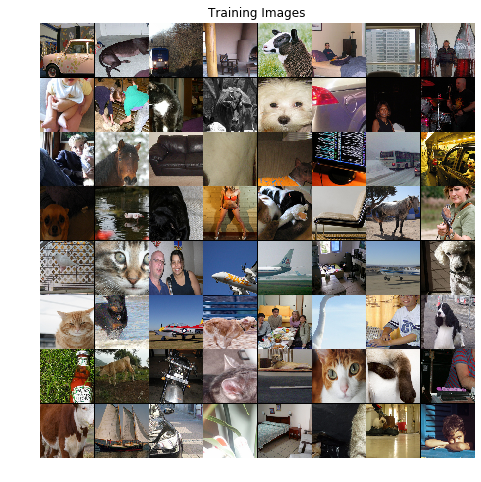

In [106]:
real_batch = next(iter(loader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], nrow=8, padding=2, normalize=True),(1,2,0)))

In [167]:
optimizer = optim.Adam(mod_model.parameters())
criterion = nn.CrossEntropyLoss()

In [168]:
mod_model = mod_model.to(device)
if(num_gpu > 1):
    mod_model = nn.DataParallel(model)

In [169]:
if os.path.isfile('./models/pretrained_model.pt'):
    mod_model.load_state_dict(torch.load('./models/pretrained_model.pt'))
    print("Loaded model from file.")
else:
    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch,num_epochs))
        print('-'*10)

        for i, data in enumerate(loader_train):
            batch_since = time.time()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = mod_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if i%10 == 0:
                batch_till = time.time()
                print('Batch: {}/{} \t Loss: {}  \t Time: {}'.format(i, len(loader_train), loss, batch_till-batch_since))
        till = time.time()
        print("Epoch Time: {}\n".format(till - since))

    if(num_gpu > 1):
        torch.save(mod_model.module.state_dict(), './models/pretrained_model.pt')
        print('Model saved.')
    else:
        torch.save(mod_model.state_dict(), './models/pretrained_model.pt')
        print('Model saved.')

Loaded model from file.


In [170]:
confusion = np.zeros((20,20))
for i, data in enumerate(loader_train):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        predicted_labels = mod_model(inputs)
        _, predicted_labels = torch.max(predicted_labels, 1)
        for i,pre in enumerate(labels):
            confusion[pre,predicted_labels[i]] += 1

In [171]:
for i in range(confusion.shape[0]):
    confusion[i] /= np.sum(confusion[i])

In [172]:
print("Average accuracy: %.4f" % (np.trace(confusion)/num_classes))

Average accuracy: 0.7545


In [173]:
sorted_ids = np.argsort(np.diag(confusion))
max_classes = sorted_ids[-4:]
min_classes = sorted_ids[:4]

In [174]:
print('Best classes:', [num_to_class[i] for i in max_classes])
print('Worst classes:', [num_to_class[i] for i in min_classes])

Best classes: ['dog', 'bird', 'train', 'aeroplane']
Worst classes: ['diningtable', 'sofa', 'bottle', 'chair']
